## 1. 라이브러리 Import

In [9]:
from PIL import Image
import numpy as np
import glob
import os

In [13]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


## 2. 데이터 resize

In [48]:
len_sum = 0
def resize_images(img_path):
    global len_sum
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(32,32)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")
    len_sum += len(images)

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

265  images to be resized.
265  images resized.
가위 이미지 resize 완료!


In [49]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"

resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

284  images to be resized.
284  images resized.
바위 이미지 resize 완료!


In [51]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"

resize_images(image_dir_path)

print("보 이미지 resize 완료!")

286  images to be resized.
286  images resized.
보 이미지 resize 완료!


In [52]:
len_sum

1121

## 2-1. 이미지 데이터 이름 정리
- 데이터를 합친 경우, 이미지의 이름이 섞여있어서 이를 정리해줍니다.

In [12]:
def rename_files(folder_path):
    origin = folder_path
    for target in ["rock", "scissor", "paper"]:
        folder_path = os.path.join(origin, target)
        
        # 폴더 내의 모든 파일 가져오기
        files = os.listdir(folder_path)
        jpg_files = [file for file in files if file.endswith('.jpg')]

        # 순서대로 파일 이름 변경
        for i, file_name in enumerate(jpg_files):
            new_name = str(i+1) + '.jpg'
            os.rename(os.path.join(folder_path, file_name), os.path.join(folder_path, new_name))

# 폴더 경로 지정
folder_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
rename_files(folder_path)

In [53]:
import numpy as np

def load_data(img_path, number_of_data=len_sum):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=32
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0 
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 835 입니다.
x_train shape: (1121, 32, 32, 3)
y_train shape: (1121,)


라벨:  0


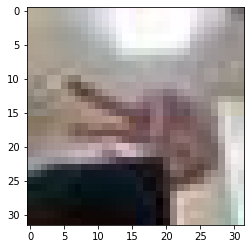

In [54]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 3. 모델 구축 및 학습

In [55]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)              

Epoch 1/30
36/36 [==============================] - 3s 57ms/step - loss: 4.1769 - accuracy: 0.5272
Epoch 2/30
36/36 [==============================] - 2s 54ms/step - loss: 0.7996 - accuracy: 0.5950
Epoch 3/30
36/36 [==============================] - 2s 56ms/step - loss: 0.7433 - accuracy: 0.6414
Epoch 4/30
36/36 [==============================] - 2s 54ms/step - loss: 0.6871 - accuracy: 0.6735
Epoch 5/30
36/36 [==============================] - 2s 55ms/step - loss: 0.7087 - accuracy: 0.6521
Epoch 6/30
36/36 [==============================] - 2s 54ms/step - loss: 0.6017 - accuracy: 0.7351
Epoch 7/30
36/36 [==============================] - 2s 55ms/step - loss: 0.5490 - accuracy: 0.7538
Epoch 8/30
36/36 [==============================] - 2s 57ms/step - loss: 0.4694 - accuracy: 0.7904
Epoch 9/30
36/36 [==============================] - 2s 53ms/step - loss: 0.4239 - accuracy: 0.8225
Epoch 10/30
36/36 [==============================] - 2s 54ms/step - loss: 0.5482 - accuracy: 0.7422
Epoch 11/

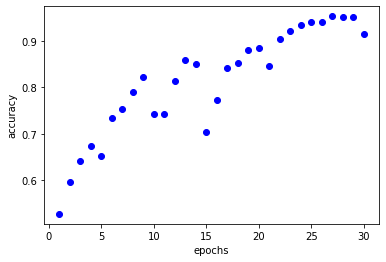

In [56]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs = 30)

acc = history.history["accuracy"]
loss = history.history["loss"]
epochs = range(1, len(acc) + 1)

# epoch에 따른 정확도 시각화
plt.plot(epochs, acc, 'bo', label="Training accuracy")
plt.plot(epochs, loss, 'ro', label="Training loss")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## 4. 모델 테스트

In [57]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (1121, 32, 32, 3)
y_test shape: (1121,)


In [58]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

36/36 - 1s - loss: 0.8088 - accuracy: 0.8287
test_loss: 0.8087611794471741 
test_accuracy: 0.8287243247032166


## 5. Pretrained Model 불러와서 성능 개선
- resnet50 모델을 불러와 Fine-tuning 후 다시 확인합니다.

Epoch 1/30
36/36 [==============================] - 8s 152ms/step - loss: 0.7958 - accuracy: 0.7886
Epoch 2/30
36/36 [==============================] - 5s 153ms/step - loss: 0.1953 - accuracy: 0.9358
Epoch 3/30
36/36 [==============================] - 5s 153ms/step - loss: 0.0979 - accuracy: 0.9706
Epoch 4/30
36/36 [==============================] - 6s 154ms/step - loss: 0.0553 - accuracy: 0.9804
Epoch 5/30
36/36 [==============================] - 5s 153ms/step - loss: 0.0400 - accuracy: 0.9875
Epoch 6/30
36/36 [==============================] - 5s 153ms/step - loss: 0.0310 - accuracy: 0.9884
Epoch 7/30
36/36 [==============================] - 5s 152ms/step - loss: 0.0342 - accuracy: 0.9902
Epoch 8/30
36/36 [==============================] - 5s 152ms/step - loss: 0.0280 - accuracy: 0.9938
Epoch 9/30
36/36 [==============================] - 6s 154ms/step - loss: 0.0618 - accuracy: 0.9777
Epoch 10/30
36/36 [==============================] - 5s 152ms/step - loss: 0.0280 - accuracy: 0.9911

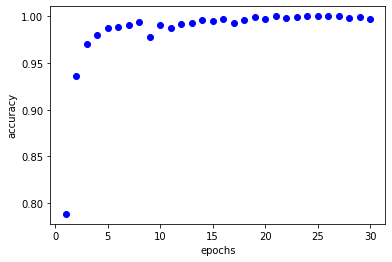

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# 기존 ResNet 모델 불러오기
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 새로운 Fully Connected 레이어 추가
x = layers.Flatten()(resnet_base.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)

# 새로운 모델 정의
model = models.Model(inputs=resnet_base.input, outputs=output)

# 기존 ResNet 레이어는 학습을 하지 않도록 설정
for layer in resnet_base.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(x_train, y_train, epochs=30, callbacks=[early_stopping])

acc = history.history["accuracy"]
epochs = range(1, len(acc) + 1)

# epoch에 따른 정확도 시각화
plt.plot(epochs, acc, 'bo', label="Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Epoch 1/10
36/36 [==============================] - 95s 2s/step - loss: 0.8450 - accuracy: 0.7966
Epoch 2/10
36/36 [==============================] - 90s 2s/step - loss: 0.1619 - accuracy: 0.9509
Epoch 3/10
36/36 [==============================] - 90s 2s/step - loss: 0.0831 - accuracy: 0.9706
Epoch 4/10
36/36 [==============================] - 89s 2s/step - loss: 0.0716 - accuracy: 0.9795
Epoch 5/10
36/36 [==============================] - 90s 3s/step - loss: 0.0521 - accuracy: 0.9822
Epoch 6/10
36/36 [==============================] - 89s 2s/step - loss: 0.0564 - accuracy: 0.9848
Epoch 7/10
36/36 [==============================] - 89s 2s/step - loss: 0.0383 - accuracy: 0.9857
Epoch 8/10
36/36 [==============================] - 89s 2s/step - loss: 0.0387 - accuracy: 0.9866
Epoch 9/10
36/36 [==============================] - 89s 2s/step - loss: 0.0727 - accuracy: 0.9866
Epoch 10/10
36/36 [==============================] - 89s 2s/step - loss: 0.0279 - accuracy: 0.9920


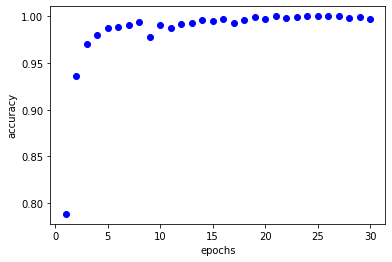

In [66]:
# 새로운 레이어를 학습하기 위해 기존 ResNet 레이어들의 학습을 해제
for layer in resnet_base.layers:
    layer.trainable = True

# 다시 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 추가 학습 (Fine-tuning)
model.fit(x_train, y_train, epochs=10)

acc = history.history["accuracy"]
epochs = range(1, len(acc) + 1)

# epoch에 따른 정확도 시각화
plt.plot(epochs, acc, 'bo', label="Training accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [67]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

36/36 - 6s - loss: 0.4755 - accuracy: 0.8724
test_loss: 0.4755222797393799 
test_accuracy: 0.8724353313446045


## 모델 개선을 위해 진행한 것
- 이미지 resize 크기 32 * 32로 확장 : 이미지의 픽셀이 너무 뭉개져서 성능이 낮아졌다고 판단 
- 모델 Conv Layer 깊이 확장 및 필터 개수 증가 : 모델이 너무 단조로워서 UnderFitting이 되었다고 판단
- Fully Connected Layer에 Dropout 레이어 추가 : 모델의 노드 수를 늘림에 따라 과적합이 발생하여 이를 줄이기 위해 Dropout layer를 추가
- **전체적인 성능 : 0.21 -> 0.82로 향상시킬 수 있었습니다.**

#### Pretrained Model을 활용하여 부족한 모델의 성능 끌어올리기
- 사전 학습되어 있는 ResNet50 모델을 불러와서 Fully Connected Layer 부분만 Fine-Tuning 해주어 전이학습 시켰습니다.
- Input shape을 맞춰주고 학습을 시켜주었습니다.
- **향상된 성능 : 0.82 -> 0.87로 성능을 향상시킬 수 있었습니다.**



##### 사용된 데이터
- Train Dataset : C3 팀원의 데이터를 합쳐서 활용하였습니다.
- Test Dataset : C4 팀의 데이터를 활용하여 검증에 활용하였습니다.

## 회고
- 이미지 데이터에 대한 별다른 전처리 과정을 거치지 않았기에 처음에는 매우 낮은 정확도를 보여주었습니다. 
- 만약 시간이 조금 더 있었다면, Histogram 평활화나 여러 다양한 방법을 적용하여 이에 대한 정확도를 비교해보았을 것 같습니다.
- 뿐만 아니라, 데이터들의 도메인이나 배경이 너무 다르다 보니까 정확도가 조금 많이 낮게 나오지 않았나 생각합니다. 
- 따라서 BackGround Remover 기법을 활용하여 데이터를 전처리 하고 비교해보고 싶었습니다.

## 관련 링크
- [**Histogram Equlization**](https://3months.tistory.com/405)
- [**BackGround Remover Github**](https://github.com/topics/background-removal)